In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from glob import glob

import cv2 as cv
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Data Cleaning

In [ ]:
mac_user = True       # Leen just change this variable to false when you use this file, so we don't need to always change

# FOLDER_PATH = "Documents/CSC413_Project/"
FOLDER_PATH = "/content/drive/MyDrive/CSC413/Project/" if mac_user else "Documents/CSC413_Project/"
zip_file = os.path.join(FOLDER_PATH, "archive.zip")
# !unzip /content/drive/MyDrive/CSC413/Project/archive.zip -d /content/drive/MyDrive/CSC413/Project
# !unzip "{zip_file}"

In [ ]:
# !ls /content/drive/MyDrive/CSC413/Project/UTKFace

In [ ]:
def get_files_in_folder(folder, use_glob=False):
  if use_glob:
    return sorted(glob(os.path.join(DATA_ROOT, "*")))
  return sorted(os.path.join(folder, f) for f in os.listdir(folder))

In [ ]:
DATA_ROOT = "/content/drive/MyDrive/CSC413/Project/UTKFace" if mac_user else "Documents/CSC413_Project/UTKFace/"
data = get_files_in_folder(DATA_ROOT, use_glob=mac_user)
data

[]

In [ ]:
from collections import defaultdict

bad_data = []

for path in data:
  path_copy = path
  image_name = path.rsplit("/")[-1]
  labels = image_name.split(".")[0].split("_")
  if len(labels) < 4:
    bad_data.append(path_copy)


if len(bad_data) > 0:
  print(f"YOU GOT SOME BAD PATHS SIR, SIZE: {len(bad_data)}")

for bad_path in bad_data:
  os.remove(bad_path)

data = get_files_in_folder(DATA_ROOT, use_glob=mac_user)

In [ ]:
class CustomError(Exception):
    """Custom exception class."""
    def __init__(self, message):
        super().__init__(message)

In [ ]:
def get_labels(path):
  """
  Returns a list of labels in the form of: [age, gender, race]
  """
  image_name = path.rsplit("/")[-1]
  labels = image_name.split(".")[0].split("_")

  if len(labels) < 4:
    raise CustomError("This was a bad path")

  return [int(label) for label in labels[:3]]

In [ ]:
age_bins = set()
ages = set()
for path in data:
  age, gender, race = get_labels(path)
  age_bin = int(age) // 6
  age_bins.add(age_bin)
  ages.add(age)

len(age_bins)

20

# Getting Train Test Data

In [ ]:
AGE_BIN_SIZE = 6
NUM_BINS = 20

In [ ]:
import numpy as np

def get_data_split(data_dir_path, show_age_hist=False):
  image_paths = get_files_in_folder(data_dir_path, use_glob=mac_user)
  images = []
  image_labels = []
  i = 0
  females = 0

  for path in image_paths:
    images.append(path)
    age, gender, _ = get_labels(path)
    image_labels.append(age // AGE_BIN_SIZE)
    # TODO: think about how to get the model to also classify the race / gender
    # separate models? or all in one??
    i += 1
    females += gender

  if show_age_hist:
    plt.hist(image_labels, bins=max(image_labels) + 1, edgecolor='black')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title('Histogram of Labels with 20 Bins')
    plt.show()
    print(len(image_paths), "female: ", females, "male: ", len(image_paths) - females)

  dataset = list(zip(images, image_labels))
  generator = torch.Generator().manual_seed(42)

  train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

  X_train, y_train = zip(*train_dataset)
  X_val, y_val = zip(*val_dataset)
  X_test, y_test = zip(*test_dataset)

  return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = get_data_split(DATA_ROOT)

In [ ]:
def get_probs(X_train, male_prob, race_probs):
  sample_probs = []

  prob_tracker = {
      "gender": {0: male_prob, 1: 1 - male_prob},
      "race": {i: race_probs[i] for i in range(len(race_probs))}
  }

  gender_count = {
      0: 0,   # Male
      1: 0    # Female
  }
  race_count = {
      0: 0,   # White
      1: 0,   # Black
      2: 0,   # Asian
      3: 0,   # Indian
      4: 0    # Other
  }

  for path in X_train:
    age, gender, race = get_labels(path)
    gender_count[gender] += 1
    race_count[race] += 1

  gender_count = {gender: 1 / count for gender, count in gender_count.items()}
  race_count = {race: 1 / count for race, count in race_count.items()}

  for path in X_train:
    age, gender, race = get_labels(path)

    gender_prob = gender_count[gender] / len(X_train) * prob_tracker["gender"][gender]
    race_prob = race_count[race] / len(X_train) * prob_tracker["race"][race]

    prob = gender_prob * race_prob

    sample_probs.append(prob)

  sum_prob = sum(sample_probs)
  normalized_probs = [prob / sum_prob for prob in sample_probs]

  return normalized_probs


def get_forget_retain_set(X_train, y_train, size, normalized_probs, is_forget=True, seed=42):
  """
  Returns the forgetset from the train_dataset

  Args:
    - X_train: X_train dataset (list of paths)
    - y_train: y_train dataset (list of ints representing bins)
    - size: percentage indicating what portion of the train_data dataset should be forget set
    - male_size: percentage indicating what portion of the forget_set should be male
  """

  np.random.seed(seed)
  num_samples = int(len(X_train) * size)
  forget_indices = np.random.choice(len(X_train), num_samples, p=normalized_probs, replace=False)

  X_train = np.array(X_train)
  y_train = np.array(y_train)

  if is_forget:
      X_forget = X_train[forget_indices]
      y_forget = y_train[forget_indices]
      return X_forget, y_forget
  else:
      retain_indices = np.setdiff1d(range(len(X_train)), forget_indices)

      X_retain = X_train[retain_indices]
      y_retain = y_train[retain_indices]

      return X_retain, y_retain


def display_distribution(X_forget):
  num_female = 0
  race_counter = {
      0: 0,
      1: 0,
      2: 0,
      3: 0,
      4: 0
  }
  for path in X_forget:
    age, gender, race = get_labels(path)
    num_female += gender
    race_counter[race] += 1

  p_female = num_female / len(X_forget)
  p_male = (len(X_forget) - num_female) / len(X_forget)

  p_white = race_counter[0] / len(X_forget)
  p_black = race_counter[1] / len(X_forget)
  p_asian = race_counter[2] / len(X_forget)
  p_indian = race_counter[3] / len(X_forget)
  p_other = race_counter[4] / len(X_forget)


  print(f"Size: {len(X_forget) / len(X_train)}")
  print(f"Female: {p_female}")
  print(f"Male: {p_male}")
  print(f"White: {p_white}")
  print(f"Black: {p_black}")
  print(f"Asian: {p_asian}")
  print(f"Indian: {p_indian}")
  print(f"Other: {p_other}")


def get_dataset(X_train, y_train, size=0.01, male_prob=0.5, race_probs=[0.2, 0.2, 0.2, 0.2, 0.2], is_forget=True, display_dist=True):

  normalized_probs = get_probs(X_train, male_prob, race_probs)

  x1, y1 = get_forget_retain_set(X_train, y_train, size, normalized_probs, is_forget=is_forget)

  if display_dist:
    print(f"Displaying: size={size}, male_size={male_prob}, race_probs={race_probs}")
    display_distribution(x1)

  return x1, y1

Displaying: size=0.002, male_size=0.5, race_probs=[0.4, 0.15, 0.15, 0.15, 0.15]
Size: 0.0019509622989717901
Female: 0.40540540540540543
Male: 0.5945945945945946
White: 0.3783783783783784
Black: 0.1891891891891892
Asian: 0.10810810810810811
Indian: 0.16216216216216217
Other: 0.16216216216216217
Displaying: size=0.01, male_size=0.3, race_probs=[0.2, 0.2, 0.2, 0.2, 0.2]
Size: 0.009965726337991036
Female: 0.6878306878306878
Male: 0.31216931216931215
White: 0.1693121693121693
Black: 0.18518518518518517
Asian: 0.2222222222222222
Indian: 0.20634920634920634
Other: 0.21693121693121692
37


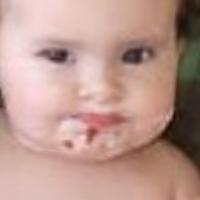

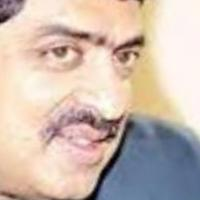

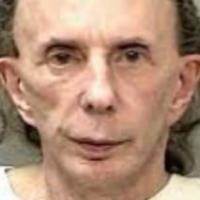

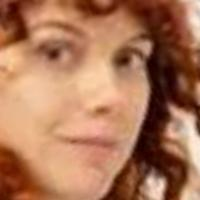

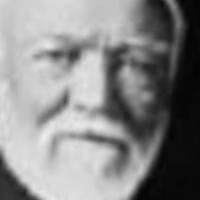

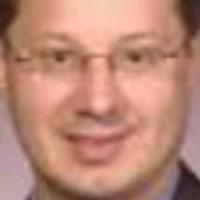

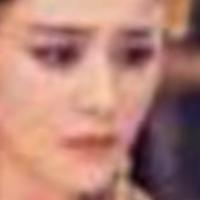

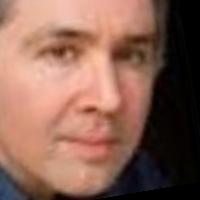

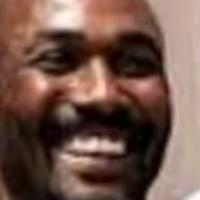

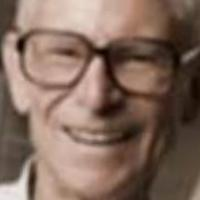

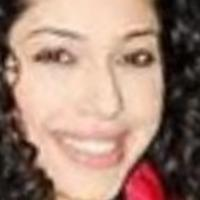

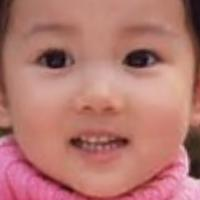

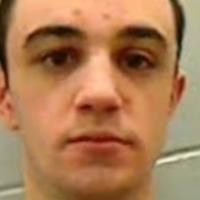

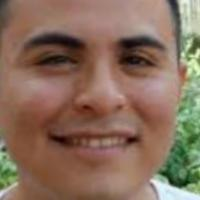

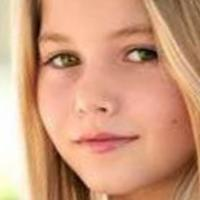

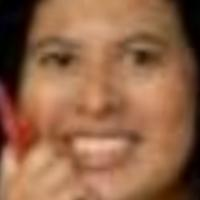

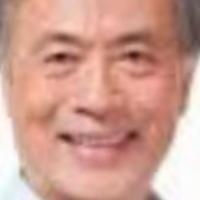

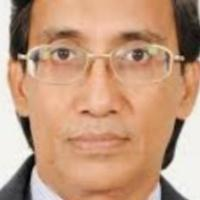

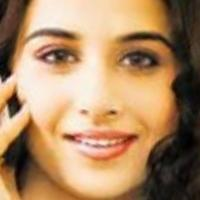

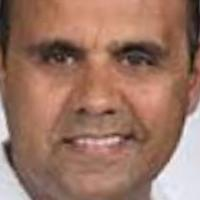

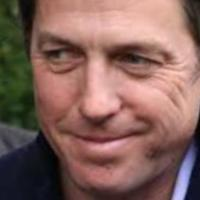

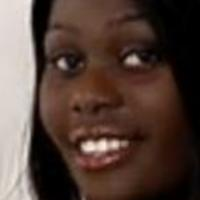

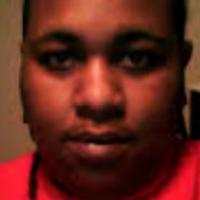

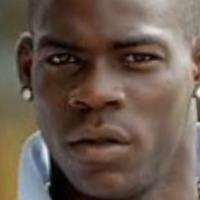

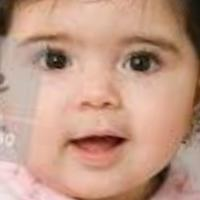

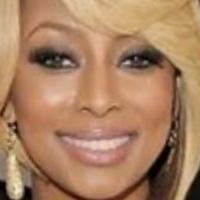

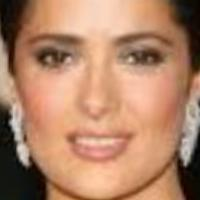

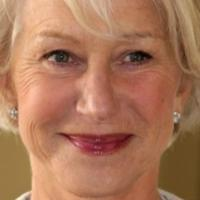

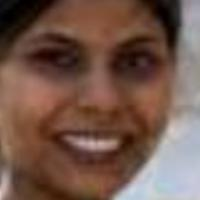

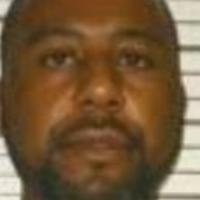

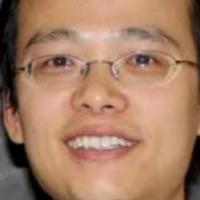

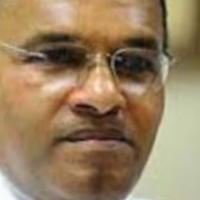

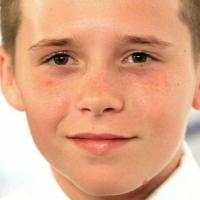

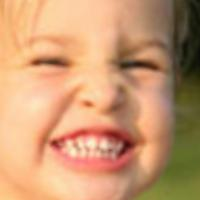

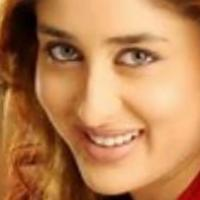

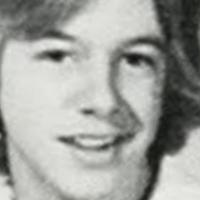

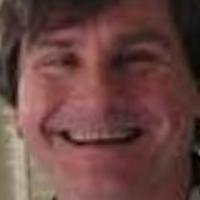

In [ ]:
# Testing
x1, y1 = get_dataset(X_train, y_train, size=0.002 , male_prob=0.5, race_probs=[0.40, 0.15, 0.15, 0.15, 0.15], display_dist=True)
x2, y2 = get_dataset(X_train, y_train, male_prob=0.3, display_dist=True)
print(len(x1))

for data in x1:
  img = cv.imread(data)
  cv2_imshow(img)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, image_data, label_data):

    self.image_data = image_data
    self.label_data = label_data

    self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

  def __len__(self):
    return len(self.image_data)

  def __getitem__(self, index):

    if isinstance(index, slice):
      # If the index is a slice object
      start = index.start if index.start is not None else 0
      stop = index.stop if index.stop is not None else len(self.data)
      step = index.step if index.step is not None else 1

      images = []
      labels = []

      for i in range(start, stop, step):
        image_path = self.image_data[i]
        images.append(self.load_image(image_path))

        label = self.label_data[i]
        labels.append(int(label) // AGE_BIN_SIZE)

      return list(zip(images, labels))

    image_path = self.image_data[index]
    label = self.label_data[index]
    image = self.load_image(image_path)
    label_one_hot = int(label) // AGE_BIN_SIZE
    return image, label_one_hot

  def load_image(self, image_path):
    image_path = str(image_path)
    image = cv.imread(image_path)
    if image is None:
      print(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).transpose(2, 0, 1)
    image = torch.tensor(image, dtype=torch.float32)
    image = self.normalize(image)
    return image

In [ ]:
BATCH_SIZE = 32

train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

train_dl = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
train_dl = DataLoader(val_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
train_dl = DataLoader(test_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)

In [ ]:
def compute_class_weights(dataset):
    labels = dataset.label_data

    # Count the occurrences of each class label
    class_counts = torch.bincount(torch.tensor(labels))
    class_proportions = class_counts.float() / len(dataset)
    class_weights = 1.0 / class_proportions

    class_weights /= class_weights.sum()

    return class_weights

class_weights = compute_class_weights(train_dataset)

# Model Definition and Training

In [ ]:
def accuracy(model, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    num_correct = 0
    N = len(data)

    # It is more efficient to process in batches rather than one by one
    batch_size = 128  # Choose an appropriate batch size depending on your GPU memory
    num_batches = (N + batch_size - 1) // batch_size

    for i in tqdm(range(num_batches), position=1, leave=False):
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, N)
        batch = data[batch_start:batch_end]

        images, labels = zip(*batch)
        images = torch.stack(images).type(torch.float32).to(device)
        labels = torch.tensor(labels).to(device)

        outputs = model(images)
        predicted_labels = outputs.argmax(dim=1)  # Assuming labels are class indices
        num_correct += (predicted_labels == labels).sum().item()

    return num_correct / N

In [ ]:
def train_model(model,
                train_data,
                val_data,
                learning_rate=0.005,
                weight_decay=0,
                batch_size=200,
                num_epochs=10,
                checkpoint=None,
                checkpoint_path="checkpoints",
                plot_every=5,
                lr_step=[5, 10],
                lr_gamma=0.1,
                plot=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    class_weights = compute_class_weights(train_dataset).to(device)
    model.to(device)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_step, gamma=lr_gamma)  # Reduce LR by a factor of 0.1 every 5 epochs

    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0
    cached_epoch = 0

    if checkpoint:
      print(f"Loading Checkpoint from Epoch {checkpoint['epoch']}, loss: {checkpoint['loss']}")
      model.load_state_dict(checkpoint["model_state_dict"])
      optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
      cached_epoch = checkpoint['epoch'] + 1

    try:
        for e in tqdm(range(cached_epoch, num_epochs + cached_epoch), position=0):
            # print(f"Starting Epoch {e} Training")
            model.train()
            for i, (images, labels) in enumerate(tqdm(train_loader, position=1, leave=False)):

                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            iter_count += 1

            scheduler.step()

            # print(f"Starting Epoch {e} Evaluation")
            if (e + 1) % plot_every == 0 or e == cached_epoch:

              model.eval()
              iters.append(iter_count)
              # ta = accuracy(model, train_data)
              va = accuracy(model, val_data)
              train_loss.append(float(loss))
              # train_acc.append(ta)
              val_acc.append(va)
              print(iter_count, "Loss:", float(loss), "Val Acc:", va)

              # make directory if it doesn't exist
              os.makedirs(os.path.join(FOLDER_PATH, checkpoint_path), exist_ok=True)
              save_path = os.path.join(FOLDER_PATH, f"{checkpoint_path}/checkpoint_{e}")

              torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
              }, save_path)

    finally:
      if plot:
        save_path = os.path.join(FOLDER_PATH, f"{checkpoint_path}")
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over epochs")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.savefig(f"{save_path}/loss_graph.png")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over epochs")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend(["Train", "Validation"])
        plt.savefig(f"{save_path}/accuracy_graph.png")

## Original Model

In [ ]:
# Model definition
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_BINS),
    nn.LogSoftmax(dim=1)
    )

checkpoint_path = None

if checkpoint_path:
  checkpoint = torch.load(checkpoint_path)


# Model training
train_model(model, train_dataset, val_dataset,
            learning_rate=0.01, weight_decay=1e-4, batch_size=100,
            num_epochs=30, plot_every=5, lr_step=[10, 20])

In [ ]:
accuracy(model, train_dataset)

In [ ]:
accuracy(model, test_dataset)

## Retain Model

In [ ]:
SIZES = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
MALE_PROBS = [0.3, 0.5, 0.7]
RACE_PROBS = [[0.2, 0.2, 0.2, 0.2, 0.2], [0.6, 0.1, 0.1, 0.1, 0.1],
              [0.1, 0.6, 0.1, 0.1, 0.1], [0.1, 0.1, 0.6, 0.1, 0.1],
              [0.1, 0.1, 0.1, 0.6, 0.1], [0.1, 0.1, 0.1, 0.1, 0.6]]

default_size = 0.02
default_gender = 0.5
default_race = [0.2, 0.2, 0.2, 0.2, 0.2]

SIZE_VARIANT = [
    {
        "name": f"{int(size * 100)}-size_{int(default_gender * 100)}-male_{'-'.join([str(int(prob * 100)) for prob in default_race])}-race",
        "size": size,
        "male_prob": default_gender,
        "race_probs": default_race,
    }
    for size in SIZES
]

GENDER_VARIANT = [
    {
        "name": f"{int(default_size * 100)}-size_{int(male_prob * 100)}-male_{'-'.join([str(int(prob * 100)) for prob in default_race])}-race",
        "size": default_size,
        "male_prob": male_prob,
        "race_probs": default_race,
    }
    for male_prob in MALE_PROBS
]

RACE_VARIANT = [
    {
        "name": f"{int(default_size * 100)}-size_{int(default_gender * 100)}-male_{'-'.join([str(int(prob * 100)) for prob in race])}-race",
        "size": default_size,
        "male_prob": default_gender,
        "race_probs": race,
    }
    for race in RACE_PROBS
]

FORGET_VARIANTS = SIZE_VARIANT + GENDER_VARIANT + RACE_VARIANT

X_train, X_val, X_test, y_train, y_val, y_test = get_data_split(DATA_ROOT)

In [ ]:
def get_retrain_models():
  if FORGET_VARIANTS is None:
    print("Something went wrong!")
    return

  for forget_variant in tqdm(FORGET_VARIANTS):

    name, size, male_prob, race_probs = forget_variant["name"], forget_variant["size"], forget_variant["male_prob"], forget_variant["race_probs"]

    print("STARTING TRAINING OF: " + name)

    model = models.resnet18(weights=None)
    model.fc = nn.Sequential(
      nn.Linear(model.fc.in_features, NUM_BINS),
      nn.LogSoftmax(dim=1)
      )

    X_train_retain, y_train_retain = get_dataset(X_train, y_train, size=size, male_prob=male_prob, race_probs=race_probs, is_forget=False)

    train_dataset = ImageDataset(X_train_retain, y_train_retain)
    val_dataset = ImageDataset(X_val, y_val)

    train_model(model, train_dataset, val_dataset,
        learning_rate=0.01, weight_decay=1e-4, batch_size=100,
        num_epochs=30, plot_every=5, lr_step=[10, 20], checkpoint_path=name)

In [ ]:
get_retrain_models()